### W205 Project 1

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install google-cloud-bigquery-storage

### Data Cleaning

First, before any analysis of the data we should look at the certain kinds of metrics of certain columns, such as miniumum and maximums. This will be useful in sighting any possible anomalies within our dataset that would likely be due to human errors, such as having certain trips that lasted over a year. These could skew our analysis results if we do not detect and handle them early on.

We first do a check on the metrics for the bikeshare_trips table below

In [152]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > result.csv

Waiting on bqjob_r21339ce9e29b6c1e_00000174e66d8d5f_1 ... (0s) Current status: DONE   


In [155]:
all_trips = pd.read_csv('result.csv')

In [156]:
all_trips.describe()

,trip_id,duration_sec,start_station_id,end_station_id,bike_number
count,1.000000e+02,100.000000,100.000000,100.0,100.000000
mean,1.043529e+06,661.830000,28.270000,83.0,291.070000
std,7.853808e+04,1265.321304,18.346197,0.0,243.514555
min,9.353460e+05,60.000000,21.000000,83.0,21.000000
25%,9.779135e+05,261.000000,22.000000,83.0,99.750000
50%,1.025123e+06,289.000000,22.000000,83.0,183.500000
75%,1.114727e+06,329.750000,22.000000,83.0,642.000000
max,1.213934e+06,6079.000000,83.000000,83.0,704.000000


We see that the measurements and values in this dataframe are reasonable (ie there are no extreme values that we should be concerned about). The minimum trip duration is 1 minute (likely because a trip shorter than that is simply rounded to 1 minute, and the longest trip is 6079 seconds or 1.69 hours.  

We can do the same for the remaining other two tables, bike_share_stations and bike_share_status

In [157]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`' > result.csv

Waiting on bqjob_r4aa84e06f3a7dcd3_00000174e66ea546_1 ... (0s) Current status: DONE   


In [158]:
all_status = pd.read_csv('result.csv')

In [159]:
all_status.describe()

,station_id,bikes_available,docks_available
count,100.000000,100.000000,100.00000
mean,6.800000,5.920000,13.04000
std,2.763397,1.001817,0.96316
min,5.000000,3.000000,12.00000
25%,5.000000,5.000000,12.00000
50%,5.000000,6.000000,13.00000
75%,11.000000,7.000000,14.00000
max,11.000000,7.000000,15.00000


We see that latitiude and longitude values vary only slightly, where latitude values start from 37.329732 and have a maximum of 37.804770, and longitude values have a min of -122.418954 and a max of -121.877349. 
We also can see that the minimum number of docks_availbale is 12, and the max is 15. 

In [160]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_stations`' > result.csv

Waiting on bqjob_r4a0f91b32bd1c9fa_00000174e66eae4b_1 ... (0s) Current status: DONE   


In [161]:
all_stations = pd.read_csv('result.csv')

In [162]:
all_stations.describe()

,station_id,latitude,longitude,dockcount
count,74.000000,74.000000,74.000000,74.000000
mean,45.513514,37.588818,-122.214046,18.162162
std,25.770985,0.204550,0.213439,4.634673
min,2.000000,37.329732,-122.418954,11.000000
25%,25.250000,37.386772,-122.400849,15.000000
50%,46.500000,37.631163,-122.312123,17.000000
75%,66.750000,37.787109,-122.058535,19.000000
max,91.000000,37.804770,-121.877349,35.000000


Again, we don't see any extreme values that would likely be a cause of human error while measuring or entering values. 

Now that we have made a sanity check to make sure that all data has an accurate representation of the world of Go Bike, we can continue exploratory data analysis next.

### Exploratory Data Analysis

In this section we ask different questions to help us formulate answers to the following two questions:

1: What are the 5 most popular trips that you would call "commuter trips"?

2: What are your recommendations for offers (justify based on your findings)?

1. How many trips per day of the week are there? 

Below we build a dataframe to see how many trips there are on each day of the week. This will help us in our understanding of the amount of commuter riders there are that use bikes to go to work and back home. Similarly, it will also allow us to see the relative activity level on weekends, another source of revenue for the company. 

In [163]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT dow_str as Day, COUNT(*) as Number_of_Trips FROM bike_trip_data.days_hours GROUP BY dow_str ORDER BY dow_str' > result.csv

Waiting on bqjob_r170802d68a4d1efe_00000174e671fb02_1 ... (0s) Current status: DONE   


In [164]:
trips_per_day = pd.read_csv('result.csv')

In [165]:
trips_per_day

,Day,Number_of_Trips
0,Friday,159977
1,Monday,169937
2,Saturday,60279
3,Sunday,51375
4,Thursday,176908
5,Tuesday,184405
6,Wednesday,180767


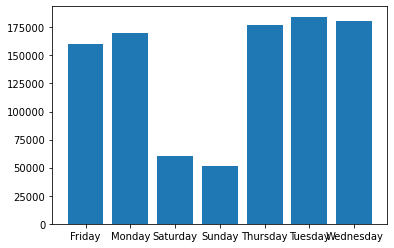

In [166]:
daily_trips = plt.bar(trips_per_day.Day, trips_per_day.Number_of_Trips)


Note that the referenced view, named "days_hours," is composed with the following SQL query:

Analysis: We can visually very clearly see the magnitude of the volume of rides between Monday and Friday. Clearly, the majority of customers for the company are commuter riders who use the bikes to go to work and go back home. However, that isn't to say that the number of riders on weekends is negligible. Theres is still about half the amount of activity on weekends as a regular week day. These could be the fewer people who need to go to work on weekends, or possibly leisure rides on weekends. To see if there is a difference in the character of rides on weekends vs. week days, let us pose the next question in part 2.

2. What is the average duration of trips on weekdays and weekends?

In [190]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend" ELSE "Weekday" END AS dow_weekday, avg(EXTRACT(HOUR FROM end_date) - EXTRACT(HOUR FROM start_date))*60 as avg_duration_minutes FROM bike_trip_data.bikeshare_trips GROUP BY dow_weekday' > result.csv



Waiting on bqjob_r6b47b588ec9b9df1_00000174e6826af2_1 ... (1s) Current status: DONE   


In [191]:
avg_duration = pd.read_csv('result.csv')

In [192]:
avg_duration

,dow_weekday,avg_duration_minutes
0,Weekday,10.806198
1,Weekend,25.550540


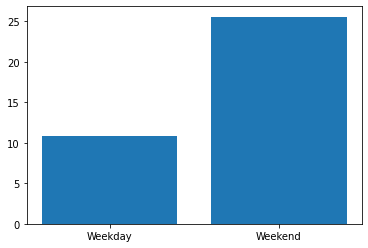

In [193]:
plt.bar(avg_duration.dow_weekday, avg_duration.avg_duration_minutes);

We can clearly see that the average duration of trips on weekends are nearly 2.5 times that of trips during the week. This supports our hypothesis that commuter trips take place mostly during the week, while longer leisure trips are likely to take place over weekends.

3. How many trips are there per hour of the day for week days only? We pose this question to get a better sense of the most busy commuter trip times during the week.

In [197]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT start_hour as Hour, COUNT(*) as Number_of_Trips FROM bike_trip_data.days_hours WHERE dow_weekday = 'Weekday' GROUP BY start_hour ORDER BY start_hour ASC" > result.csv


Waiting on bqjob_r48de717fbc299b9e_00000174e685934d_1 ... (0s) Current status: DONE   


In [198]:
trips_per_hour = pd.read_csv('result.csv')

In [199]:
trips_per_hour

,Hour,Number_of_Trips
0,0,1696
1,1,797
2,2,420
3,3,427
4,4,1273
5,5,4799
6,6,19830
7,7,65900
8,8,128999
9,9,90264


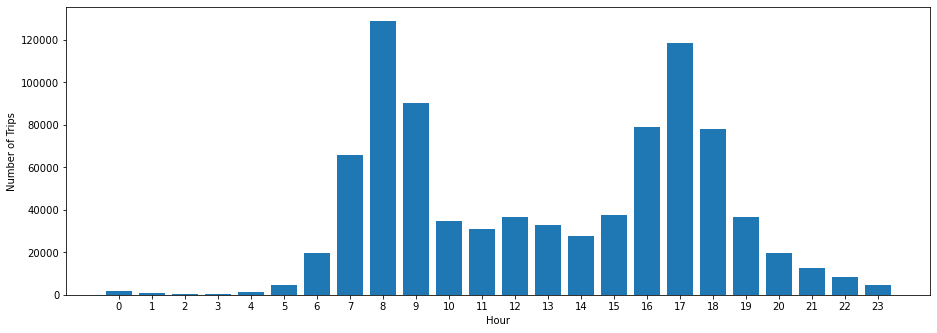

In [213]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(trips_per_hour.Hour, trips_per_hour.Number_of_Trips)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Trips")
ax.set_xticks(trips_per_hour.Hour);

We see large surges in the demand for bicycle use between 7 and 10am in the morning, and between 4 and 6pm in the evening.

Let us now see what proportion of these rides are by subscription_type cusomer versus subscriber.

In [216]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT start_hour as Hour, COUNT(*) as Number_of_Trips FROM bike_trip_data.days_hours WHERE subscriber_type = 'Customer' GROUP BY start_hour ORDER BY start_hour ASC" > result.csv


Waiting on bqjob_r14e844999201e095_00000174e68b2c1e_1 ... (0s) Current status: DONE   


In [217]:
trips_per_hour_customer = pd.read_csv('result.csv')

In [218]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT start_hour as Hour, COUNT(*) as Number_of_Trips FROM bike_trip_data.days_hours WHERE subscriber_type = 'Subscriber' GROUP BY start_hour ORDER BY start_hour ASC" > result.csv


Waiting on bqjob_r595215808db5966b_00000174e68b39ae_1 ... (0s) Current status: DONE   


In [219]:
trips_per_hour_subscriber = pd.read_csv('result.csv')

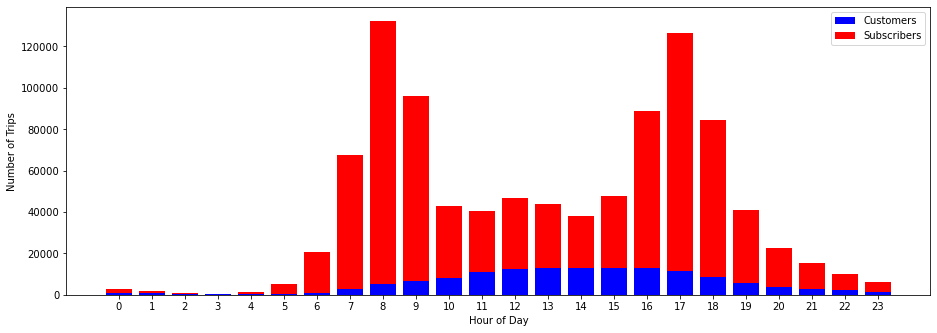

In [221]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(trips_per_hour['Hour'], trips_per_hour_customer['Number_of_Trips'], color='b')
ax.bar(trips_per_hour['Hour'], trips_per_hour_subscriber['Number_of_Trips'], bottom=trips_per_hour_customer['Number_of_Trips'], color='r')
ax.set_xticks(trips_per_hour['Hour']);
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Trips")
ax.legend(labels=['Customers','Subscribers']);

We can see that subscribers make up the vast majority of rides during the weekdays, who are especially active between 7 and 10am in the morning, and between 4 and 6pm in the evening.

Please note that the following is the query used to create the view, named "days_hours," that is referenced in the queries above.

3. Map the top 5 station locations for the morning and evening trips We pose this question to gain understanding into where trips end both in the morning and at night. Our hypothesis may be that morning trips end in business zones, while those in the evening are more likely to end in relatively more residential areas, as people might be going back home.

We will use our findings from the previous section, to determine the top 5 most common end_trip_stations in the morning and evening times (between 7 and 10am, and 4 and 6pm).

In [276]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT end_station_name, latitude, longitude, count(*) as count_at_start_station FROM bike_trip_data.bikeshare_trips as trips, bike_trip_data.bikeshare_stations as stations WHERE trips.end_station_name = stations.name and EXTRACT(HOUR from trips.start_date) >= 7 and EXTRACT(HOUR from trips.start_date) <= 10 GROUP BY end_station_name, latitude, longitude ORDER BY count_at_start_station DESC LIMIT 5" > result.csv


Waiting on bqjob_r5955c926af056f68_00000174e6a10b17_1 ... (0s) Current status: DONE   


In [277]:
lat_long_morning = pd.read_csv('result.csv')

In [278]:
lat_long_morning

,end_station_name,latitude,longitude,count_at_start_station
0,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,22532
1,2nd at Townsend,37.780526,-122.390288,19384
2,Townsend at 7th,37.771058,-122.402717,19241
3,Embarcadero at Sansome,37.804770,-122.403234,15669
4,Market at Sansome,37.789625,-122.400811,15183


In [279]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT end_station_name, latitude, longitude, count(*) as count_at_start_station FROM bike_trip_data.bikeshare_trips as trips, bike_trip_data.bikeshare_stations as stations WHERE trips.end_station_name = stations.name and EXTRACT(HOUR from trips.start_date) >= 16 and EXTRACT(HOUR from trips.start_date) <= 19 GROUP BY end_station_name, latitude, longitude ORDER BY count_at_start_station DESC LIMIT 5" > result.csv

Waiting on bqjob_r14310d9da5dd7f76_00000174e6a116fd_1 ... (0s) Current status: DONE   


In [280]:
lat_long_evening = pd.read_csv('result.csv')

In [281]:
lat_long_evening

,end_station_name,latitude,longitude,count_at_start_station
0,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,48809
1,San Francisco Caltrain 2 (330 Townsend),37.776600,-122.395470,33878
2,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,21249
3,Steuart at Market,37.794139,-122.394434,17143
4,Temporary Transbay Terminal (Howard at Beale),37.789756,-122.394643,16336


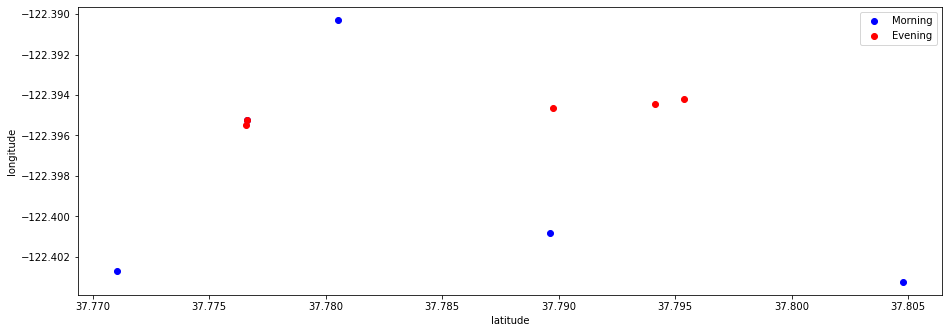

In [284]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.scatter(lat_long_morning['latitude'], lat_long_morning['longitude'], color='b')
ax.scatter(lat_long_evening['latitude'], lat_long_evening['longitude'], color='r')
# ax.set_xticks(lat_long_morning['latitude'])
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")
ax.legend(labels=['Morning', 'Evening']);

When we look at one of these points as an example in Google Maps, we see that one of the morning locations (37.790, -122.401) is in the financial district in San Francisco near the Mission District, and at the cross-section between Market and Sutter Streets. This is an area with many offices and businesses. 

On the other hand within the evening locations if we look at (37.777, -122.395) we see that we are the address, 301 Townsend St, San Francisco in a relatively more residential area of San Francisco. Therefore, we can conclude that most of the commuter trips are actually taking place within San Francisco itself. It is possible that people are taking public transport and then renting a Go Bike to take the shorter ride to work and back home.  

With the exception of the "San Francisco Caltrain (Townsend at 4th)" station, which is on the top 5 stations for morning and evening, our findings are consistent with our hypothesis that morning trips end near business zones. Evening commutes, on the other hand, end closer to residential areas, where rent and house prices are also slightly more affordable, comparing to areas like the financial district in San Francisco. 

4. Now we will look at the possible missed opportunities on the weekend. 

We pose the question, "What is the average percentage of bikes that are used from each station on weekends?"

To make the judgement fair, we will also reduce to hours between 8am and 8pm. 

In [285]:
! bq query --use_legacy_sql=FALSE --format=csv "SELECT station_id, CAST(round(avg(bikes_available)) as int64) as avg_bikes_available, cast(round(avg(docks_available)) as int64) as avg_docks_available, cast((avg(docks_available) - avg(bikes_available)) / avg(docks_available) *100 as int64) as percentage_in_use FROM bike_trip_data.bikeshare_status WHERE (EXTRACT(DAYOFWEEK from time) = 7 or EXTRACT(DAYOFWEEK from time) = 1) and (EXTRACT(HOUR FROM time) > 8 and EXTRACT(HOUR FROM time) < 20) GROUP BY station_id ORDER BY station_id" > result.csv



Waiting on bqjob_r4644c5b2b90bd96f_00000174e6a1ff1a_1 ... (0s) Current status: DONE   


In [286]:
bikes_used_weekend = pd.read_csv('result.csv')

In [287]:
bikes_used_weekend.head(10)

,station_id,avg_bikes_available,avg_docks_available,percentage_in_use
0,2,13,14,2
1,3,8,7,-25
2,4,5,6,12
3,5,8,11,34
4,6,7,8,4
5,7,8,7,-13
6,8,7,7,0
7,9,8,7,-7
8,10,7,8,22
9,11,9,10,7


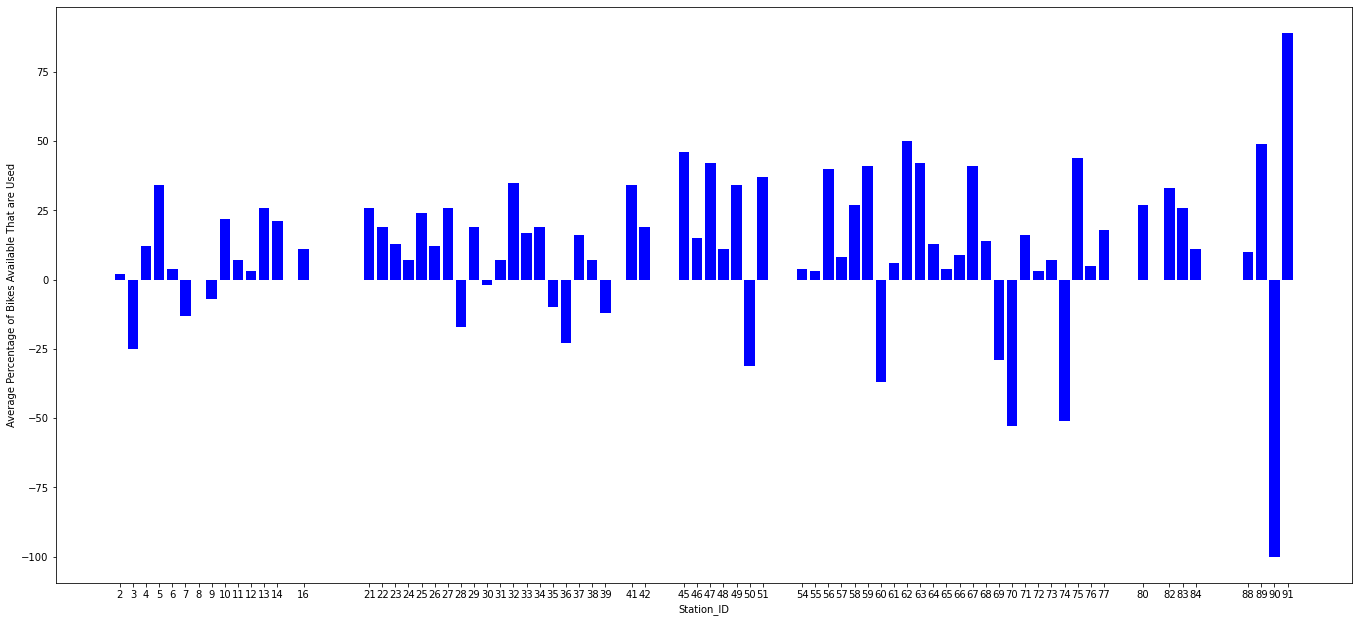

In [288]:
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
ax.bar(bikes_used_weekend.station_id, bikes_used_weekend.percentage_in_use, color='b')
ax.set_xticks(bikes_used_weekend.station_id)
ax.set_xlabel("Station_ID")
ax.set_ylabel("Average Percentage of Bikes Available That are Used");

What we see is missed opportunity. with the exclusion of station 91, most of the stations have a maximum average usage of bikes available at that station of 50%. In some cases where there is a negative percentage use, there is in fact an average surplus of bikes available at that station. This means that there are many bikes that are sitting idle and not generating revenue for the company, especially on weekends. 

### Summary and Conclusion

Through our exploratory data analysis carried out above, we can devise our reponses to the following questions:

### 1--What are the 5 most popular trips that you would call "commuter trips"?

1. Trips during the week between Monday and Friday are a popular commuter trip. This is likely due to most people having Monday-Friday jobs that require them to get to work using some form of transportation.
2. We find that commuter trips have an average of about 10.8 minutes, while leisure trips are nearly 25 minutes on average. 
3. Surge hours for commuter trips are between 7 and 10am in the morning, and between 4 and 6pm in the evening. 
4. The vast majority of commuter trips are by subscribers, as opposed to customers. 
5. Morning commutes are to business districts, such as the financial center or the Mission district, while commuter trips in the evening are most popular to more residential areas but still very close to or within San Francisco. This may be due to people also taking bikes to their closest Bart or Bus stations, and then heading out of San Francisco to go home.

 

### 2 What are your recommendations for offers (justify based on your findings)?

1. Increase weekend activity. We saw that while weekend bike trips are almost 2.5 times longer on average per trip, the total number of trips is much lower on weekends. Furthermore, as seen in the last part of the exploratory data analysis section, the average bike utilisation with respect to total bikes available is almost 50%. This means that almost 50% of the bikes are idle and not generating revenue. It would be wise to have promotions which incentivize shorter commuter trips during the week (about 10 minutes) and longer leisure trips (about 25 minutes) on the weekends.
2. Increase subscription levels. While it is true that the majority of riders are subscription holders, it is important to accumulate more long term customers by incentivizing subscriptions. Perhaps offering the first month at a reduced price, to lure customers in, could be a sensible business decision to increase the subscription levels even further. This would yield more consistent longer0term revenue for the company as subscibing customers are more likely to pay the next month too, while non-subscription riders are less likely. 